In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
import re
import string
import matplotlib.pyplot as plt
import nltk
import ssl
import random


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Functions to process the Tweets

In [3]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mbocquel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The process_tweet function is able to process the tweet by removing hyperlinks, apply a stemmer, remove the stopwords, and tokenize them. 

In [4]:
def process_tweet(tweet):
    """
    Input:
        tweet: a string containing a tweet
    Output:
        tweets_clean: a list of words containing the processed tweet

    """
    stemmer = PorterStemmer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    #tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
            word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            stem_word = stemmer.stem(word)  # stemming word
            tweets_clean.append(stem_word)
    return tweets_clean

In [5]:
# Example of process_tweet function
process_tweet(" Stop the Annihilation of the Salt River Wild Horse... http://t.co/SB5R7ShcCJ via @Change")

['stop', 'annihil', 'salt', 'river', 'wild', 'hors', '...', 'via']

# Analysis of the Dataset

In [6]:
df = pd.read_csv("data/train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### How balanced is the dataset ?

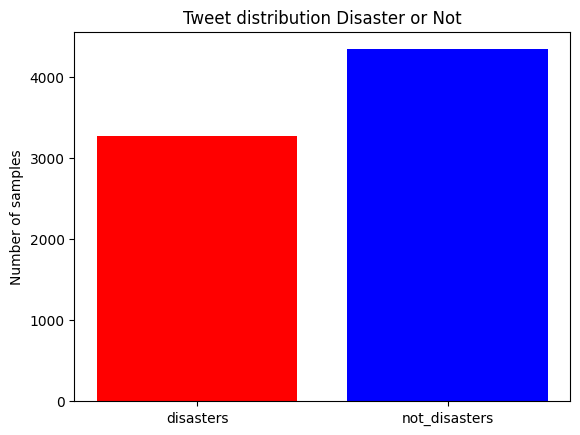

In [7]:
disasters = df[df.loc[:,"target"] == 1]
not_disasters = df[df.loc[:,"target"] == 0]
fig, ax = plt.subplots()
ax.bar(["disasters", "not_disasters"], [disasters.shape[0], not_disasters.shape[0]], color=['red', 'blue'])
ax.set_ylabel('Number of samples')
ax.set_title('Tweet distribution Disaster or Not')
plt.show()


The dataset is not to badly balanced. We can monitor the accuracy that should be a pretty good metric. But we can also monitor the F1 Score as it can be more interesting, and it's what our model will be evaluated by Kaggle.

### Impact of localisation

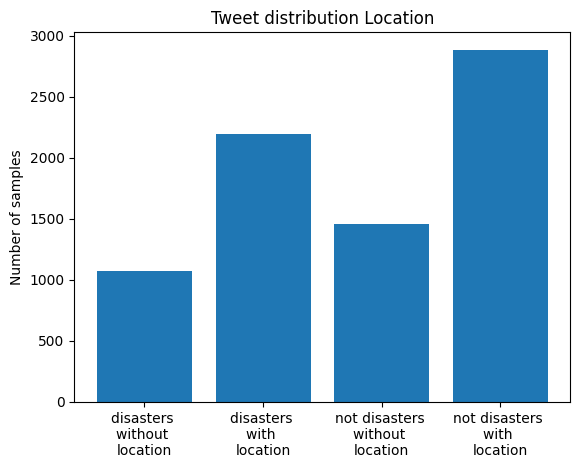

In [8]:
disasters_no_location = disasters[disasters.loc[:,"location"].isna()]
disasters_location = disasters[disasters.loc[:,"location"].isna() == False]
not_disasters_no_location = not_disasters[not_disasters.loc[:,"location"].isna()]
not_disasters_location = not_disasters[not_disasters.loc[:,"location"].isna() == False]
label = ['disasters \nwithout \nlocation', 'disasters \nwith \nlocation', 'not disasters \nwithout \nlocation', 'not disasters \nwith \nlocation']
counts = [disasters_no_location.shape[0], disasters_location.shape[0], not_disasters_no_location.shape[0], not_disasters_location.shape[0]]

fig, ax = plt.subplots()
ax.bar(label, counts)
ax.set_ylabel('Number of samples')
ax.set_title('Tweet distribution Location')
plt.show()

In [9]:
part_no_location_disaster = round((disasters_no_location.shape[0] / disasters.shape[0]) * 100, 2)
part_no_location_not_disaster = round((not_disasters_no_location.shape[0] / not_disasters.shape[0]) * 100, 2)
print(f"Part of Disasters Tweets with no location {part_no_location_disaster}%")
print(f"Part of Not Disasters Tweets with no location {part_no_location_not_disaster}%")

Part of Disasters Tweets with no location 32.86%
Part of Not Disasters Tweets with no location 33.58%


There is not a big difference in the presence of location information for Disaster Tweets or Not Disaters Tweets. This information will not be very interesting to discriminate tweets. We will therefore not use it

### Impact of the Keyword

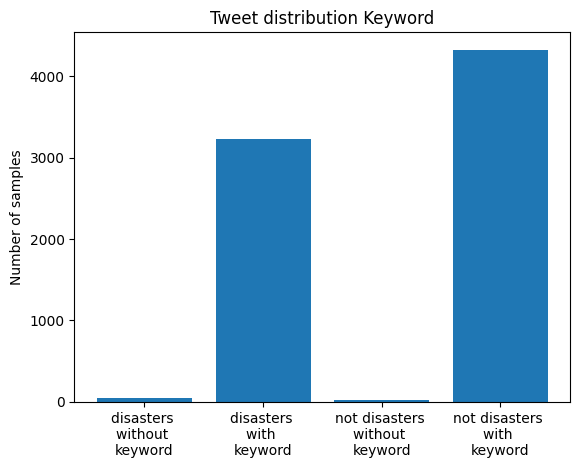

Part of Disasters Tweets with no location 1.28%
Part of Not Disasters Tweets with no location 0.44%


In [10]:
disasters = df[df.loc[:,"target"] == 1]
not_disasters = df[df.loc[:,"target"] == 0]
disasters_no_kw = disasters[disasters.loc[:,"keyword"].isna()]
disasters_kw = disasters[disasters.loc[:,"keyword"].isna() == False]
not_disasters_no_kw = not_disasters[not_disasters.loc[:,"keyword"].isna()]
not_disasters_kw = not_disasters[not_disasters.loc[:,"keyword"].isna() == False]
label = ['disasters \nwithout \nkeyword', 'disasters \nwith \nkeyword', 'not disasters \nwithout \nkeyword', 'not disasters \nwith \nkeyword']
counts = [disasters_no_kw.shape[0], disasters_kw.shape[0], not_disasters_no_kw.shape[0], not_disasters_kw.shape[0]]

fig, ax = plt.subplots()
ax.bar(label, counts)
ax.set_ylabel('Number of samples')
ax.set_title('Tweet distribution Keyword')
plt.show()

part_no_kw_disaster = round((disasters_no_kw.shape[0] / disasters.shape[0]) * 100, 2)
part_no_kw_not_disaster = round((not_disasters_no_kw.shape[0] / not_disasters.shape[0]) * 100, 2)
print(f"Part of Disasters Tweets with no location {part_no_kw_disaster}%")
print(f"Part of Not Disasters Tweets with no location {part_no_kw_not_disaster}%")

In [11]:
disasters_kw.iloc[random.sample(list(range(disasters_kw.shape[0])), 20), :]


,id,keyword,location,text,target
3817,5425,first%20responders,NaN,Carmike Cinemas on Antioch Shooting: 'We Are G...,1
1369,1973,bush%20fires,"iPhone: -27.499212,153.011072",@marcoarment Middle of winter in Sydney we hav...,1
6439,9212,suicide%20bombing,Istanbul,INFOGRAPHIC: At least 20 Turkish security offi...,1
6575,9410,survivors,NaN,#WorldNews\n Fears over missing migrants in Me...,1
3593,5132,fatal,NaN,California man facing manslaughter charge in S...,1
6515,9317,survive,Kansas,Escaping her captors was the 1st step. Now she...,1
2176,3119,debris,Campo Grande-MS,[Reuters] Debris confirmed from MH370; relativ...,1
7410,10601,wounded,"Illinois, USA",Let's not forget our wounded female veterans. ...,1
6078,8684,sinkhole,"Haddonfield, NJ",Georgia sinkhole closes road swallows whole po...,1
6471,9255,sunk,NaN,Japan FUSO Class Battleship YAMASHIRO Naval Co...,1


The keywords seems to give information on the disaster. However, this information may not be that interesting if the words are also in the text. We will test that. 

In [12]:
def analyse_keyword_in_text(df):
	"""
    Input:
        df: a dataframe of tweets with at least [keyword] and [text] collums
    Output:
        The percentage of tweet with the keyword included in the text 
    """
	in_text = 0
	count = 0
	for keyword, text in zip(df.loc[:,"keyword"], df.loc[:,"text"]):
		keyword = keyword.replace("%20", " ")
		if keyword in text:
			in_text += 1
		count += 1
	return round((in_text / count) * 100, 2)

print(f"Part of Disaster tweet that contains their keyword in the text feature : {analyse_keyword_in_text(disasters_kw)}%")

Part of Disaster tweet that contains their keyword in the text feature : 60.11%


The information of the keyword is often contained in the text itself. I will therefore not use this feature, at least in my first models

# Dataset Class

In [13]:
class MyDataset(Dataset):
    def __init__(self, data, name="dataset") -> None:
        super().__init__()
        self.name = name
        text, target = data
        self.text = np.array(text)
        self.n_samples = len(self.text)
        if target:
            self.target = np.array(target)
        else:
            self.target = (-1) * np.ones(self.n_samples, dtype=np.int32)

    def __getitem__(self, index):
        return (self.text[index], self.target[index])
    
    def __len__(self):
        return self.n_samples
    
    def get_stats(self):
        print('--------------------')
        print(self.name)
        for val, nb in np.array(np.unique(self.target , return_counts=True)).T:
            print(f"{val}   {nb}")
        print('--------------------')


In [14]:
def splitTrainVal(path, valid_size):
    """
    Input:
        path (string): The path to the csv file that contains the data
        valid_size (float): the part of the data to use for validation
    Output:
        X_train, X_valid, Y_train, Y_valid (list) : The features and the target for
        the train set and the validation set. 
    """
    df = pd.read_csv(path)
    df.drop(columns=["id", "keyword", "location"], inplace=True)
    np_data = df.to_numpy()
    np.random.shuffle(np_data)
    (X_train, X_valid,
        Y_train, Y_valid) = train_test_split(list(np_data[:,0]),
                                            list(np_data[:,1]),
                                            test_size=valid_size,
                                            shuffle=True,
                                            stratify = list(np_data[:,1]),
                                            random_state=None)
    return (X_train, X_valid, Y_train, Y_valid)

In [15]:
# Train et Val
X_train, X_valid, Y_train, Y_valid = splitTrainVal("data/train.csv", 0.2)
train_dataset = MyDataset((X_train, Y_train), name="Train")
val_dataset = MyDataset((X_valid, Y_valid), name="Val")


In [51]:
train_dataset.get_stats()
val_dataset.get_stats()


--------------------
Train
0   3473
1   2617
--------------------
--------------------
Val
0   869
1   654
--------------------


# Tokenisation

In [17]:
def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield process_tweet(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), min_freq = 2, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

text_pipeline = lambda x: vocab(process_tweet(x))
label_pipeline = lambda x: int(x)

In [18]:
vocab_size = len(vocab)
print(f"The vocabulary is of size {vocab_size}")

The vocabulary is of size 4760


In [19]:
def tokeniseDataset(sentenses, tokenizer):
    """
    Input:
        sentenses : list of strings
        tokenizer : Function that transform a string into tokens (with stem, no stop words etc.)
    Output:
       list of list of tokens
    """
    return [tokenizer(sentense) for sentense in sentenses]


def getMaxLenTweet(sentenses, tokenizer):
    """
    Input:
        sentenses : list of strings
        tokenizer : Function that transform a string into tokens (with stem, no stop words etc.)
    Output:
        number of token in the longuest tweet
    """
    text_tokenised = tokeniseDataset(sentenses, tokenizer)
    return max(len(txt) for txt in text_tokenised)


def transformSenToIntMat(sentenses, tokenizer, vocab, max_num_token):
    """
    Input:
        sentenses : list of strings
        tokenizer : Function that transform a string into tokens (with stem, no stop words etc.)
        vocab: the Pytorch vocabulary 
        max_num_token: The max number of tokens for a Tweet. 
    Output:
        A matrix (number of sentenses, maxmax_num_token), with the tweets transform into numbers and pad with 0 at the front.
    """
    text_tokenised = tokeniseDataset(sentenses, tokenizer)
    vocab_list = [vocab(text) for text in text_tokenised]
    return np.array([[0] * (max_num_token - len(sous_liste)) + sous_liste for sous_liste in vocab_list], dtype=np.int32)

In [20]:
# Get the size of the input feature vector 
nb_features = max(
    getMaxLenTweet(train_dataset.text, process_tweet),
    getMaxLenTweet(val_dataset.text, process_tweet),
    getMaxLenTweet(test_dataset.text, process_tweet))

print(f"Our data set (train and test) has {nb_features} tokens max. This will be the shape of the text vector")

Our data set (train and test) has 29 tokens max. This will be the shape of the text vector


# Dataloader

In [21]:
def collate_batch(batch):
    """
    Input:
        batch : list of (tweet_text, label)
    Output:
        (sentenses_mat, label) (both torch.tensor) : sentenses_mat contains the matrix of tokens ids for the tweets, 
            label contains the target value for each tweet
    """
    sentenses = [elem[0] for elem in batch]
    sentenses_mat = torch.from_numpy(transformSenToIntMat(sentenses, process_tweet, vocab, nb_features)).to(device)
    label = torch.from_numpy(np.array([elem[1] for elem in batch]).reshape(len(sentenses), 1)).to(device)
    return sentenses_mat, label

This collate_batch function will be used to transform the text in a token list when we call the Dataloader to get data

In [22]:
dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

In [23]:
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)

# Trainning functions

In [24]:
def compute_acc(model, dataloader):
    """
    Input:
        model: a Pytorch NN.Model
        dataloader: a Pytorch datamodel
    Output:
        The accuracy of the model 
    """
    model.eval()
    true = []
    total_num = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            probs = torch.sigmoid(model(X_batch))
            y_hat = (probs >= 0.5).int()
            y_batch = torch.reshape(y_batch, (y_batch.shape[0],))
            y_hat = torch.reshape(y_hat, (y_hat.shape[0],))
            test = y_hat == y_batch
            true.append(sum(test).tolist())
            total_num.append(len(y_batch))
    acc = (sum(true) / sum(total_num)) * 100
    return acc


In [25]:
def compute_loss(loss, model, dataloader):
    """
    Input:
        loss: The loss functon to use
        model: a Pytorch NN.Model
        dataloader: a Pytorch datamodel
    Output:
        The average loss of the model on a set of data
    """
    model.eval()
    all_losses = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            probs = model(X_batch)
            y_batch = y_batch.type(torch.float32)
            all_losses.append(loss(probs, y_batch).item())
    return np.mean(all_losses)

In [26]:
def precision_and_recall(y_hat, y_true):
	"""
    Input:
        y_hat (torch.tensor) : predicted values of the model
        y_true (torch.tensor) : target values
    Output:
        (precision, recall)
    """
	truePos = torch.sum((y_hat == 1) & (y_true == 1))
	falsePos = torch.sum((y_hat == 1) & (y_true == 0))
	falseNeg = torch.sum((y_hat == 0) & (y_true == 1))
	precision = 0
	recall = 0
	if (truePos + falsePos) != 0:
		precision = (truePos / (truePos + falsePos))
	if (truePos + falseNeg) != 0:
		recall = (truePos / (truePos + falseNeg))
	return precision, recall


In [27]:
def compute_f1(model, dataloader):
    """
    Input:
        model: a Pytorch NN.Model
        dataloader: a Pytorch datamodel
    Output:
        F1 Score (float)
    """
    y_hat = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            probs = torch.sigmoid(model(X_batch))
            y_hat_batch = (probs >= 0.5).int()
            y_hat_batch = torch.reshape(y_hat_batch, (y_hat_batch.shape[0],))
            y_hat.append(y_hat_batch.tolist())
            y_true.append(torch.reshape(y_batch, (y_batch.shape[0],)).tolist())
    y_hat = torch.tensor([elem for sous_list in y_hat for elem in sous_list]).to(device)
    y_true = torch.tensor([elem for sous_list in y_true for elem in sous_list]).to(device)
    precision, recall = precision_and_recall(y_hat, y_true)
    f1_score = (2 * precision * recall) / (precision + recall)
    return float(f1_score)

In [28]:
def train_model(model, optimizer, dataloader, val_dataloader, n_epochs=10, loss_fn=nn.BCEWithLogitsLoss(), 
                train_loss=[], val_loss=[], acc_train=[],
                acc_val=[], f1_train=[], f1_val=[]):
    """
    Input:
        model: a Pytorch NN.Model
        optimizer: Pytorch optimizer initiated for the model
        dataloader: The Pytorch dataloader for trainning
        val_dataloader: The Pytorch dataloader for validation
        n_epochs=10 : The number of epochs for the trainning
        loss_fn=nn.BCEWithLogitsLoss() : The function used to train the model
        train_loss (list): list used to store the train loss of each epoch
        val_loss (list): list used to store the validation loss of each epoch
        acc_train (list): list used to store the train accuracy of each epoch
        acc_val (list): list used to store the validation accuracy of each epoch
        f1_train (list): list used to store the train f1 score of each epoch
        f1_val (list): list used to store the validation f1 score of each epoch
    Output:
        train_loss (list): input train_loss with the new values appended
        val_loss (list): input val_loss with the new values appended
        acc_train (list): input acc_train with the new values appended
        acc_val (list): input acc_val with the new values appended
        f1_train (list): input f1_train with the new values appended
        f1_val (list): input f1_val with the new values appended
    """
    for epoch in range(n_epochs):
        model.train()
        loss_tr = []
        for  idx, ( X_batch, y_batch) in enumerate(dataloader):
            optimizer.zero_grad()
            probs = model(X_batch)
            y_batch = y_batch.type(torch.float32)
            loss = loss_fn(probs, y_batch)
            loss_tr.append(loss.item())
            loss.backward()
            optimizer.step()
            model.zero_grad()
        train_loss.append(np.mean(loss_tr))
        val_loss.append(compute_loss(loss_fn, model, val_dataloader))
        acc_train.append(compute_acc(model, dataloader))
        acc_val.append(compute_acc(model, val_dataloader))
        f1_train.append(compute_f1(model, dataloader))
        f1_val.append(compute_f1(model, val_dataloader))
        
        print(f"Epoch: {epoch}, train_loss={train_loss[-1]:.4f}, val_loss={val_loss[-1]:.4f}, acc_train={acc_train[-1]:.4f}, acc_val={acc_val[-1]:.4f}, f1_train={f1_train[-1]:.4f}, f1_val={f1_val[-1]:.4f}  ")
    return train_loss, val_loss, acc_train, acc_val, f1_train, f1_val

In [29]:
def plot_trainning_metrics(train_loss, val_loss, acc_train, acc_val, f1_train, f1_val):
	"""
    Input:
        val_loss (list): list used to store the validation loss of each epoch
        acc_train (list): list used to store the train accuracy of each epoch
        acc_val (list): list used to store the validation accuracy of each epoch
        f1_train (list): list used to store the train f1 score of each epoch
        f1_val (list): list used to store the validation f1 score of each epoch
    Output:
		No return values
    """
	x = range(len(train_loss))
	train_loss_round = np.round(train_loss, 3)
	val_loss_round = np.round(val_loss, 3)
	acc_train_round = np.round(acc_train, 3)
	acc_val_round = np.round(acc_val, 3)
	f1_train_round = np.round(f1_train, 3)
	f1_val_round = np.round(f1_val, 3)
	plt.figure(figsize=(13, 7))
	plt.subplot(1, 3, 1)
	plt.plot(x, train_loss_round, "b", label="Training Set")
	plt.plot(x, val_loss_round, "r", label="Validation Set")
	plt.xlabel("epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.title(f"Evolution of the loss")

	plt.subplot(1, 3, 2)
	plt.plot(x, acc_train_round, "b", label="Training Set")
	plt.plot(x, acc_val_round, "r", label="Validation Set")
	plt.xlabel("epoch")
	plt.ylabel("Accuracy")
	plt.legend()
	plt.title(f"Evolution of the Accuracy")

	plt.subplot(1, 3, 3)
	plt.plot(x, f1_train_round, "b", label="Training Set")
	plt.plot(x, f1_val_round, "r", label="Validation Set")
	plt.xlabel("epoch")
	plt.ylabel("F1")
	plt.legend()
	plt.title(f"Evolution of the F1 Score")
	plt.show()

# Model 1, RNN, petite regularisation L2 de 0,01

In [30]:
class MyModel(nn.Module):
    def __init__(self, vocab_size, hidden_size=8, embedding_size=32, num_layers=1, dense_dim=16, num_class=1):
        super(MyModel, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True) #batch first = True veut dire que la shape de l'input est (batch_size, seq, input_size)
        self.dense2 = nn.Linear(hidden_size, num_class)

    def forward(self,x, h_0=None):
        """
        Run the forward pass

        Parameters : 
            x : torch.tensor. Shape (n_sample, input_size)
            h_0 : torch.tensor ou None.
                Initial Hidden state of the RRN.
        Return : 
            output : torch.tensor (batch size, Sequence Lenght, hidden_size)
            h_n : torch.tensor final hidden state for each element in the batch
        """
        emb = self.embedding(x)
        if h_0 is not None:
            _, h = self.rnn(emb, h_0)
        else:
            _, h = self.rnn(emb)
        h_mean = h.mean(dim=0)
        result_final = self.dense2(h_mean)
        return result_final


In [31]:
model = MyModel(vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)

In [32]:
train_loss_history, val_loss_history, acc_train_history, acc_val_history, f1_train_history, f1_val_history = [], [], [], [], [], []

In [33]:
(train_loss_history,
 val_loss_history,
 acc_train_history,
 acc_val_history,
 f1_train_history,
 f1_val_history) = train_model(
	 model,
	 optimizer,
	 dataloader,
	 val_dataloader,
	 n_epochs=30,
	 train_loss=train_loss_history,
	 val_loss=val_loss_history, 
	 acc_train=acc_train_history,
	 acc_val=acc_val_history,
	 f1_train=f1_train_history,
	 f1_val=f1_val_history)

Epoch: 0, train_loss=0.6870, val_loss=0.6744, acc_train=58.1281, acc_val=59.6192, f1_train=0.2975, f1_val=0.3067  
Epoch: 1, train_loss=0.6750, val_loss=0.6708, acc_train=59.0969, acc_val=59.8162, f1_train=0.2667, f1_val=0.2697  
Epoch: 2, train_loss=0.6709, val_loss=0.6689, acc_train=59.5402, acc_val=60.0131, f1_train=0.2348, f1_val=0.2435  
Epoch: 3, train_loss=0.6684, val_loss=0.6682, acc_train=59.5731, acc_val=59.9475, f1_train=0.2345, f1_val=0.2413  
Epoch: 4, train_loss=0.6658, val_loss=0.6670, acc_train=59.6552, acc_val=60.1445, f1_train=0.2525, f1_val=0.2660  
Epoch: 5, train_loss=0.6611, val_loss=0.6600, acc_train=61.6913, acc_val=60.3414, f1_train=0.4660, f1_val=0.4237  
Epoch: 6, train_loss=0.6467, val_loss=0.6457, acc_train=63.8424, acc_val=63.0991, f1_train=0.4870, f1_val=0.4254  
Epoch: 7, train_loss=0.6334, val_loss=0.6372, acc_train=65.7635, acc_val=63.8214, f1_train=0.4878, f1_val=0.4120  
Epoch: 8, train_loss=0.6170, val_loss=0.6182, acc_train=67.8654, acc_val=65.9225

In [34]:
# Saving the model
torch.save(model, "model1.pth")

# Model 2, RNN avec dense layer sans regularisation

In [31]:
class MyModel_2_RNN_Dense(nn.Module):
    def __init__(self, vocab_size, hidden_size=8, embedding_size=32, num_layers=1, dense_dim=16, num_class=1):
        super(MyModel_2_RNN_Dense, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.rnn = nn.RNN(embedding_size, hidden_size, num_layers, batch_first=True) #batch first = True veut dire que la shape de l'input est (batch_size, seq, input_size)
        self.dense1 = nn.Linear(hidden_size, dense_dim)
        self.dense2 = nn.Linear(dense_dim, num_class)

    def forward(self,x, h_0=None):
        """
        Run the forward pass

        Parameters : 
            x : torch.tensor. Shape (n_sample, input_size)
            h_0 : torch.tensor ou None.
                Initial Hidden state of the RRN.
        Return : 
            output : torch.tensor (batch size, Sequence Lenght, hidden_size)
            h_n : torch.tensor final hidden state for each element in the batch
        """
        emb = self.embedding(x)
        if h_0 is not None:
            _, h = self.rnn(emb, h_0)
        else:
            _, h = self.rnn(emb)
        h_mean = h.mean(dim=0)
        result_dense1 = torch.sigmoid(self.dense1(h_mean))
        result_final = self.dense2(result_dense1)
        return result_final


In [32]:
model2 = MyModel_2_RNN_Dense(vocab_size).to(device)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [37]:
train_loss_history2, val_loss_history2, acc_train_history2, acc_val_history2, f1_train_history2, f1_val_history2 = [], [], [], [], [], []

In [38]:
(train_loss_history2,
 val_loss_history2,
 acc_train_history2,
 acc_val_history2,
 f1_train_history2,
 f1_val_history2) = train_model(
	 model2,
	 optimizer2,
	 dataloader,
	 val_dataloader,
	 n_epochs=30,
	 train_loss=train_loss_history2,
	 val_loss=val_loss_history2,
	 acc_train=acc_train_history2,
	 acc_val=acc_val_history2,
	 f1_train=f1_train_history2,
	 f1_val=f1_val_history2)

Epoch: 0, train_loss=0.6942, val_loss=0.6775, acc_train=57.0279, acc_val=57.0584, f1_train=nan, f1_val=nan  
Epoch: 1, train_loss=0.6704, val_loss=0.6542, acc_train=63.9409, acc_val=63.3618, f1_train=0.4090, f1_val=0.3895  
Epoch: 2, train_loss=0.6233, val_loss=0.5879, acc_train=73.5796, acc_val=70.9783, f1_train=0.6465, f1_val=0.5960  
Epoch: 3, train_loss=0.5460, val_loss=0.5430, acc_train=78.7028, acc_val=74.5896, f1_train=0.7219, f1_val=0.6554  
Epoch: 4, train_loss=0.4852, val_loss=0.5283, acc_train=81.7241, acc_val=75.7715, f1_train=0.7681, f1_val=0.6827  
Epoch: 5, train_loss=0.4406, val_loss=0.5173, acc_train=83.9901, acc_val=77.2817, f1_train=0.8020, f1_val=0.7117  
Epoch: 6, train_loss=0.4086, val_loss=0.5172, acc_train=85.4023, acc_val=77.8070, f1_train=0.8164, f1_val=0.7164  
Epoch: 7, train_loss=0.3809, val_loss=0.5199, acc_train=86.8473, acc_val=77.6100, f1_train=0.8373, f1_val=0.7207  
Epoch: 8, train_loss=0.3537, val_loss=0.5271, acc_train=88.0788, acc_val=78.0039, f1_t

In [39]:
# Saving the model
torch.save(model2, "model2.pth")

# Model 3, LSTM, sans regularisation

In [33]:
class MyModel_3_LSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=8, embedding_size=32, num_layers=1, dense_dim=16, num_class=1):
        super(MyModel_3_LSTM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.dense_dim = dense_dim
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True)
        self.dense = nn.Linear(hidden_size, num_class)

    def forward(self,x, h_0=None, c_0=None):
        """
        Run the forward pass

        Parameters : 
            x : torch.tensor. Shape (n_sample, input_size)
            h_0 : torch.tensor ou None.
                Initial Hidden state of the RRN.
        Return : 
            output : torch.tensor (batch size, Sequence Lenght, hidden_size)
            h_n : torch.tensor final hidden state for each element in the batch
        """
        emb = self.embedding(x)
        if h_0 is not None and c_0 is not None:
            _, (h, c) = self.lstm(emb, h_0, c_0)
        else:
            _, (h, c) = self.lstm(emb)
        h_mean = h.mean(dim=0)
        result_final = self.dense(h_mean)
        return result_final


In [41]:
model3 = MyModel_3_LSTM(vocab_size).to(device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=1e-3)

In [42]:
train_loss_history3, val_loss_history3, acc_train_history3, acc_val_history3, f1_train_history3, f1_val_history3 = [], [], [], [], [], []

In [43]:
(train_loss_history3,
 val_loss_history3,
 acc_train_history3,
 acc_val_history3,
 f1_train_history3,
 f1_val_history3) = train_model(
	 model3,
	 optimizer3,
	 dataloader,
	 val_dataloader,
	 n_epochs=30,
	 train_loss=train_loss_history3,
	 val_loss=val_loss_history3,
	 acc_train=acc_train_history3,
	 acc_val=acc_val_history3,
	 f1_train=f1_train_history3,
	 f1_val=f1_val_history3)

Epoch: 0, train_loss=0.6712, val_loss=0.6539, acc_train=62.2660, acc_val=60.6041, f1_train=0.2769, f1_val=0.2208  
Epoch: 1, train_loss=0.6295, val_loss=0.6108, acc_train=70.3612, acc_val=66.1195, f1_train=0.5823, f1_val=0.5038  
Epoch: 2, train_loss=0.5674, val_loss=0.5697, acc_train=75.8949, acc_val=71.1753, f1_train=0.6698, f1_val=0.5931  
Epoch: 3, train_loss=0.4976, val_loss=0.5368, acc_train=80.0164, acc_val=73.7360, f1_train=0.7368, f1_val=0.6454  
Epoch: 4, train_loss=0.4373, val_loss=0.5189, acc_train=83.2841, acc_val=75.2462, f1_train=0.7840, f1_val=0.6769  
Epoch: 5, train_loss=0.3889, val_loss=0.5137, acc_train=85.7143, acc_val=75.8372, f1_train=0.8221, f1_val=0.7013  
Epoch: 6, train_loss=0.3530, val_loss=0.5127, acc_train=87.3892, acc_val=76.6907, f1_train=0.8424, f1_val=0.7083  
Epoch: 7, train_loss=0.3176, val_loss=0.5277, acc_train=89.1626, acc_val=76.7564, f1_train=0.8697, f1_val=0.7264  
Epoch: 8, train_loss=0.2891, val_loss=0.5415, acc_train=90.2463, acc_val=77.0190

In [44]:
# Saving the model
torch.save(model3, "model3.pth")

# Model 4, LSTM avec regularisation L2 de 0,01

In [45]:
model4 = MyModel_3_LSTM(vocab_size).to(device)
optimizer4 = torch.optim.Adam(model4.parameters(), lr=1e-3, weight_decay=0.01)

In [46]:
train_loss_history4, val_loss_history4, acc_train_history4, acc_val_history4, f1_train_history4, f1_val_history4 = [], [], [], [], [], []

In [47]:
(train_loss_history4,
 val_loss_history4,
 acc_train_history4,
 acc_val_history4,
 f1_train_history4,
 f1_val_history4) = train_model(
	 model4,
	 optimizer4,
	 dataloader,
	 val_dataloader,
	 n_epochs=30,
	 train_loss=train_loss_history4,
	 val_loss=val_loss_history4,
	 acc_train=acc_train_history4,
	 acc_val=acc_val_history4,
	 f1_train=f1_train_history4,
	 f1_val=f1_val_history4)

Epoch: 0, train_loss=0.6810, val_loss=0.6784, acc_train=57.0279, acc_val=57.0584, f1_train=nan, f1_val=nan  
Epoch: 1, train_loss=0.6752, val_loss=0.6705, acc_train=58.6535, acc_val=57.7807, f1_train=0.1052, f1_val=0.0748  
Epoch: 2, train_loss=0.6641, val_loss=0.6584, acc_train=61.3793, acc_val=60.6041, f1_train=0.3155, f1_val=0.2857  
Epoch: 3, train_loss=0.6525, val_loss=0.6522, acc_train=63.3498, acc_val=62.5739, f1_train=0.4191, f1_val=0.3777  
Epoch: 4, train_loss=0.6461, val_loss=0.6508, acc_train=64.1215, acc_val=63.3618, f1_train=0.4478, f1_val=0.4038  
Epoch: 5, train_loss=0.6412, val_loss=0.6469, acc_train=64.2365, acc_val=63.4274, f1_train=0.4731, f1_val=0.4252  
Epoch: 6, train_loss=0.6383, val_loss=0.6390, acc_train=64.9918, acc_val=64.6750, f1_train=0.5543, f1_val=0.5118  
Epoch: 7, train_loss=0.6333, val_loss=0.6412, acc_train=65.6486, acc_val=64.4780, f1_train=0.4561, f1_val=0.3996  
Epoch: 8, train_loss=0.6257, val_loss=0.6254, acc_train=67.3071, acc_val=66.1195, f1_t

In [48]:
# Saving the model
torch.save(model4, "model4.pth")

Autres idees : Utiliser un calque Embedding deja entraine. 


# Model 5, LSTM avec regularisation L2 de 0,02

In [49]:
model5 = MyModel_3_LSTM(vocab_size).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=1e-3, weight_decay=0.02)

In [50]:
train_loss_history5, val_loss_history5, acc_train_history5, acc_val_history5, f1_train_history5, f1_val_history5 = [], [], [], [], [], []

In [51]:
(train_loss_history5,
 val_loss_history5,
 acc_train_history5,
 acc_val_history5,
 f1_train_history5,
 f1_val_history5) = train_model(
	 model5,
	 optimizer5,
	 dataloader,
	 val_dataloader,
	 n_epochs=30,
	 train_loss=train_loss_history5,
	 val_loss=val_loss_history5,
	 acc_train=acc_train_history5,
	 acc_val=acc_val_history5,
	 f1_train=f1_train_history5,
	 f1_val=f1_val_history5)

Epoch: 0, train_loss=0.6786, val_loss=0.6723, acc_train=57.0115, acc_val=57.0584, f1_train=nan, f1_val=nan  
Epoch: 1, train_loss=0.6726, val_loss=0.6690, acc_train=59.0969, acc_val=58.8969, f1_train=0.1287, f1_val=0.1083  
Epoch: 2, train_loss=0.6690, val_loss=0.6648, acc_train=59.6880, acc_val=59.5535, f1_train=0.1874, f1_val=0.1676  
Epoch: 3, train_loss=0.6655, val_loss=0.6616, acc_train=60.1314, acc_val=60.0131, f1_train=0.2055, f1_val=0.1847  
Epoch: 4, train_loss=0.6617, val_loss=0.6614, acc_train=60.7225, acc_val=60.6697, f1_train=0.2985, f1_val=0.2686  
Epoch: 5, train_loss=0.6619, val_loss=0.6588, acc_train=60.8867, acc_val=59.6192, f1_train=0.2932, f1_val=0.2284  
Epoch: 6, train_loss=0.6596, val_loss=0.6585, acc_train=61.1823, acc_val=60.3414, f1_train=0.3408, f1_val=0.2740  
Epoch: 7, train_loss=0.6592, val_loss=0.6590, acc_train=61.2808, acc_val=59.9475, f1_train=0.3395, f1_val=0.2615  
Epoch: 8, train_loss=0.6592, val_loss=0.6592, acc_train=61.5271, acc_val=60.0131, f1_t

In [52]:
# Saving the model
torch.save(model5, "model5.pth")

# Analysis of the model performances

### Model 1
RNN, petite regularisation L2 de 0,01

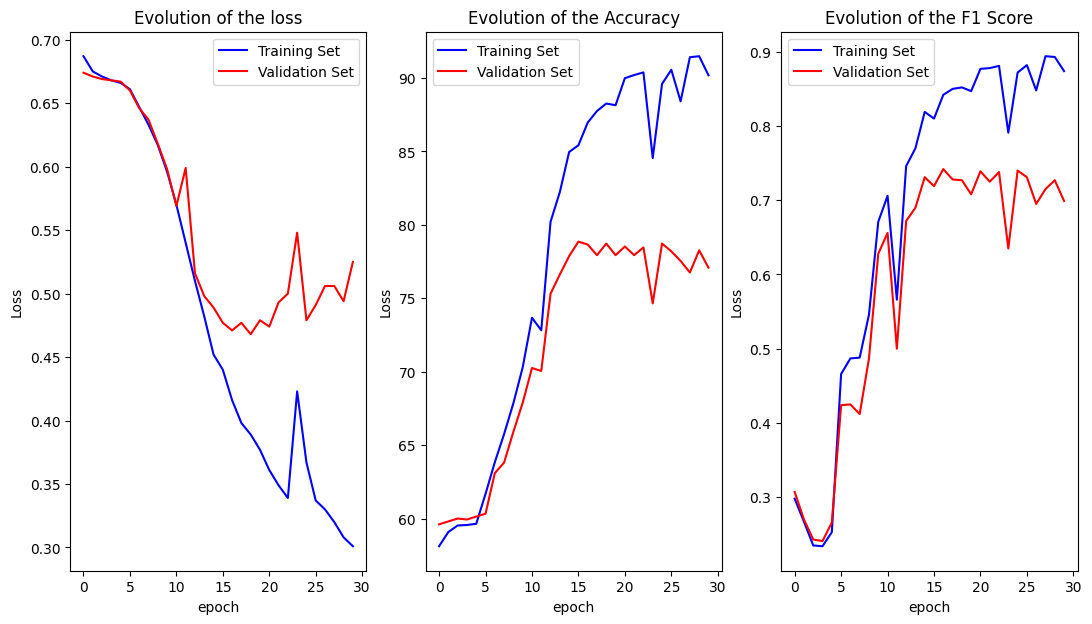

In [53]:
plot_trainning_metrics(train_loss_history, val_loss_history, acc_train_history, acc_val_history, f1_train_history, f1_val_history)

### Model 2
RNN avec dense layer sans regularisation

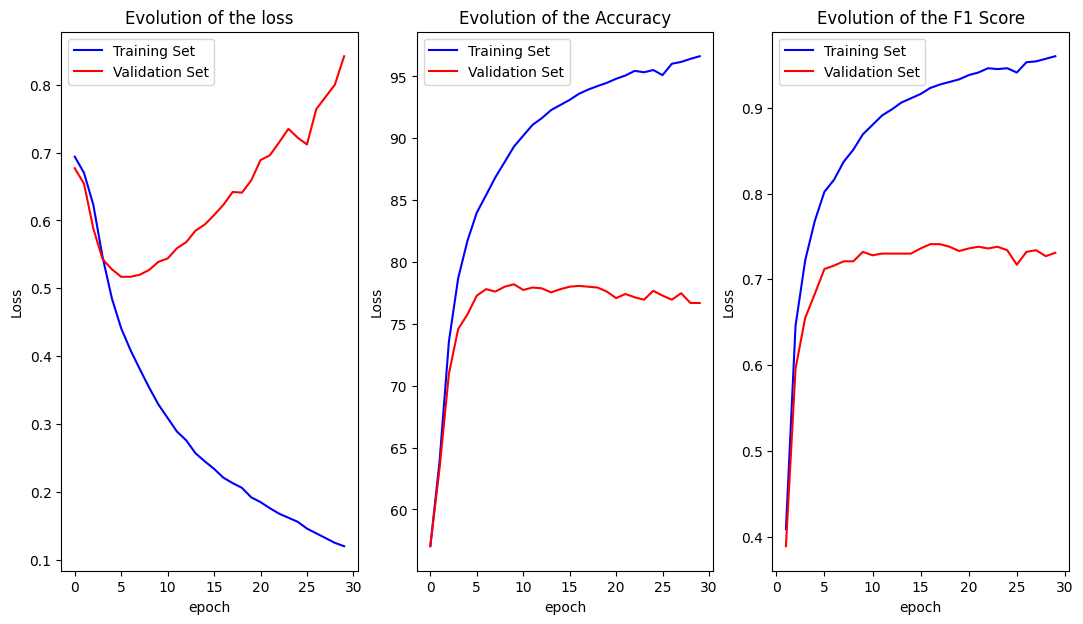

In [54]:
plot_trainning_metrics(train_loss_history2, val_loss_history2, acc_train_history2, acc_val_history2, f1_train_history2, f1_val_history2)

### Model 3
LSTM, sans regularisation

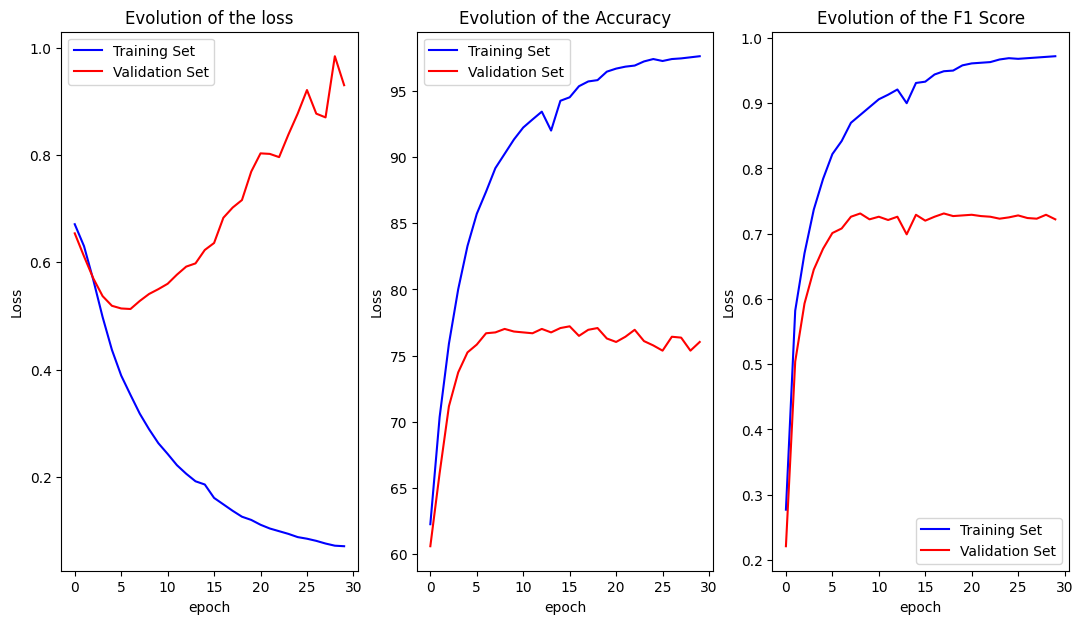

In [55]:
plot_trainning_metrics(train_loss_history3, val_loss_history3, acc_train_history3, acc_val_history3, f1_train_history3, f1_val_history3)

### Model 4
LSTM avec regularisation L2 de 0,01

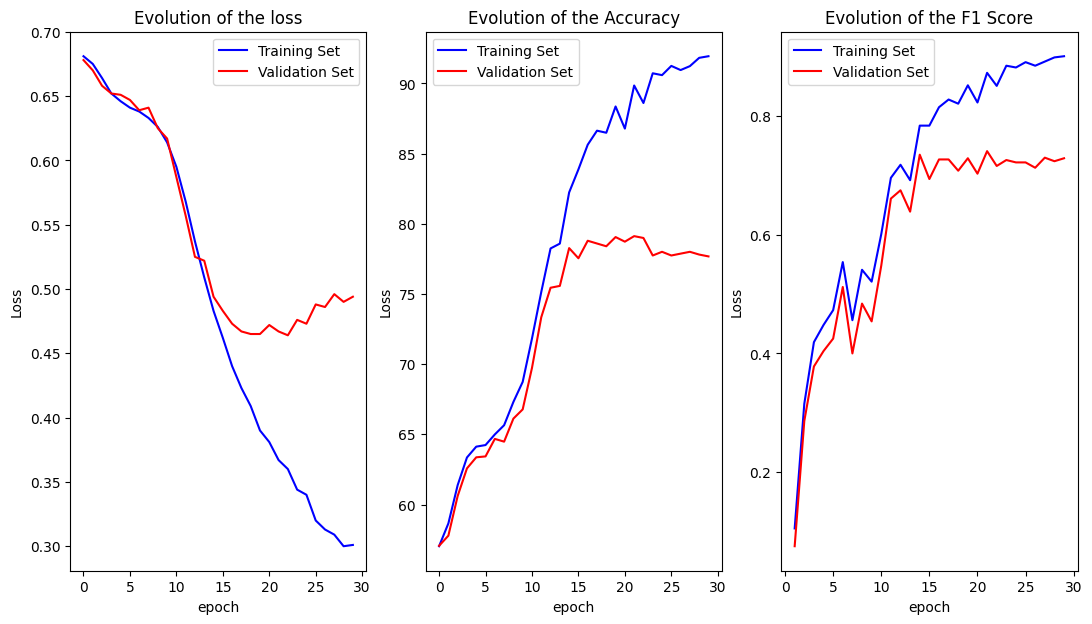

In [56]:
plot_trainning_metrics(train_loss_history4, val_loss_history4, acc_train_history4, acc_val_history4, f1_train_history4, f1_val_history4)

### Model 5
LSTM avec regularisation L2 de 0,02

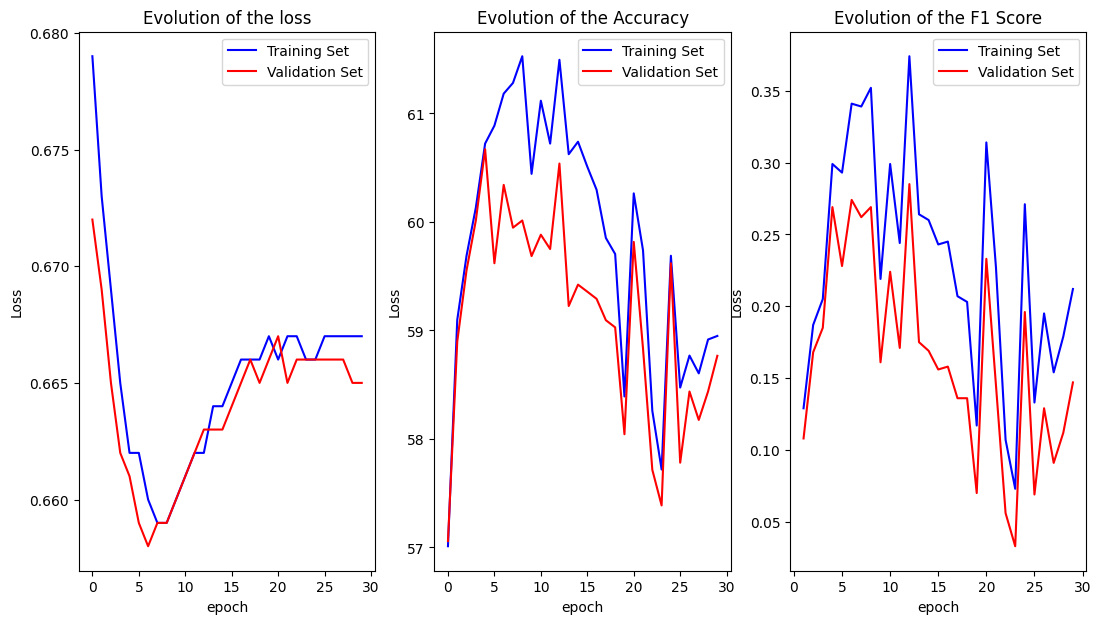

In [57]:
plot_trainning_metrics(train_loss_history5, val_loss_history5, acc_train_history5, acc_val_history5, f1_train_history5, f1_val_history5)

# Evaluation of the models

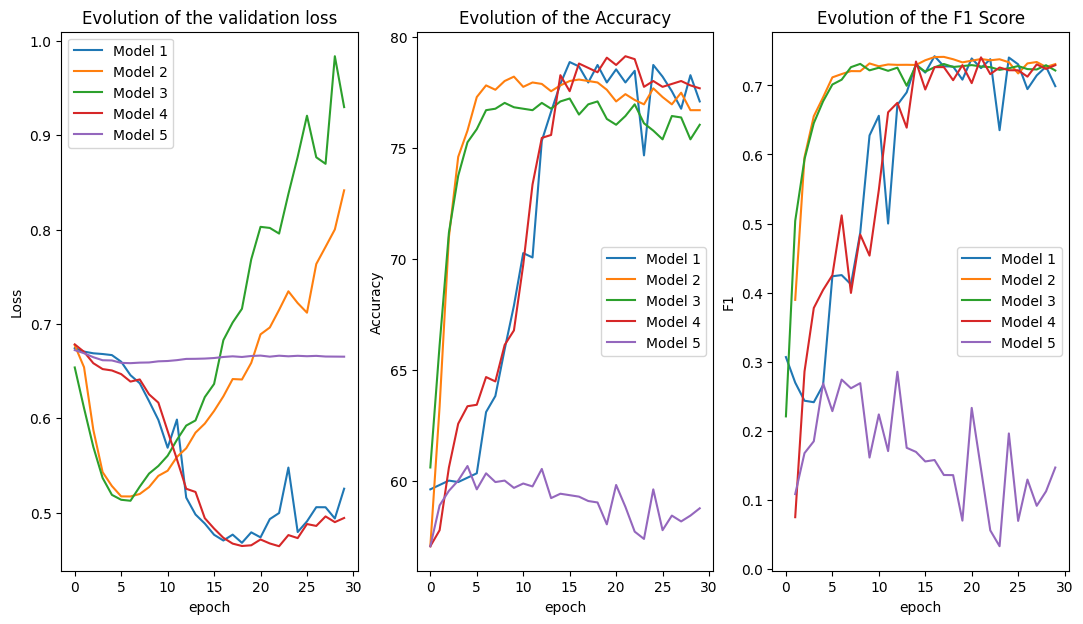

In [60]:
x = range(len(f1_val_history))
plt.figure(figsize=(13, 7))
plt.subplot(1, 3, 1)
plt.plot(x, val_loss_history, label="Model 1")
plt.plot(x, val_loss_history2, label="Model 2")
plt.plot(x, val_loss_history3, label="Model 3")
plt.plot(x, val_loss_history4, label="Model 4")
plt.plot(x, val_loss_history5, label="Model 5")
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()
plt.title(f"Evolution of the validation loss")

plt.subplot(1, 3, 2)
plt.plot(x, acc_val_history, label="Model 1")
plt.plot(x, acc_val_history2, label="Model 2")
plt.plot(x, acc_val_history3, label="Model 3")
plt.plot(x, acc_val_history4, label="Model 4")
plt.plot(x, acc_val_history5, label="Model 5")
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title(f"Evolution of the Accuracy")

plt.subplot(1, 3, 3)
plt.plot(x, f1_val_history, label="Model 1")
plt.plot(x, f1_val_history2, label="Model 2")
plt.plot(x, f1_val_history3, label="Model 3")
plt.plot(x, f1_val_history4, label="Model 4")
plt.plot(x, f1_val_history5, label="Model 5")
plt.xlabel("epoch")
plt.ylabel("F1")
plt.legend()
plt.title(f"Evolution of the F1 Score")
plt.show()


I will use the model 4 and stopping the learning around 18 epochs before it start to overfit. 

# Prediction

In [34]:
model_final = MyModel_3_LSTM(vocab_size).to(device)
optimizer_final = torch.optim.Adam(model_final.parameters(), lr=1e-3, weight_decay=0.01)

In [35]:
(train_loss_history_final,
 val_loss_history_final,
 acc_train_history_final,
 acc_val_history_final,
 f1_train_history_final,
 f1_val_history_final) = train_model(
	 model_final,
	 optimizer_final,
	 dataloader,
	 val_dataloader,
	 n_epochs=18,
	 )

Epoch: 0, train_loss=0.6927, val_loss=0.6768, acc_train=59.4581, acc_val=59.0282, f1_train=0.3697, f1_val=0.3333  
Epoch: 1, train_loss=0.6667, val_loss=0.6630, acc_train=60.5419, acc_val=61.0637, f1_train=0.2707, f1_val=0.2688  
Epoch: 2, train_loss=0.6562, val_loss=0.6539, acc_train=62.4302, acc_val=61.9173, f1_train=0.4035, f1_val=0.3856  
Epoch: 3, train_loss=0.6507, val_loss=0.6490, acc_train=63.3826, acc_val=62.4425, f1_train=0.4655, f1_val=0.4425  
Epoch: 4, train_loss=0.6484, val_loss=0.6482, acc_train=63.3990, acc_val=63.3618, f1_train=0.4970, f1_val=0.4909  
Epoch: 5, train_loss=0.6453, val_loss=0.6453, acc_train=63.9409, acc_val=62.9678, f1_train=0.4811, f1_val=0.4598  
Epoch: 6, train_loss=0.6412, val_loss=0.6427, acc_train=64.5977, acc_val=64.2154, f1_train=0.5469, f1_val=0.5330  
Epoch: 7, train_loss=0.6374, val_loss=0.6372, acc_train=64.7619, acc_val=64.4780, f1_train=0.4753, f1_val=0.4680  
Epoch: 8, train_loss=0.6317, val_loss=0.6304, acc_train=66.2890, acc_val=65.6599

In [36]:
torch.save(model_final, "model_final.pth")

# Prediction


In [64]:
model_final = torch.load("model_final.pth")

In [60]:
# Test
df_test = pd.read_csv("data/test.csv")
df_test.drop(columns=["keyword", "location"], inplace=True)

submission_sentenses_mat = torch.from_numpy(transformSenToIntMat(df_test["text"].to_list(), process_tweet, vocab, nb_features)).to(device)
submission_id = df_test["id"].to_list()

In [75]:
with torch.no_grad():
    probs = torch.sigmoid(model_final(submission_sentenses_mat))
    y_hat_test = (probs >= 0.5).int()
    y_hat_test = torch.reshape(y_hat_test, (y_hat_test.shape[0],))


In [76]:
y_hat_test

tensor([1, 0, 1,  ..., 1, 1, 0], device='mps:0', dtype=torch.int32)

In [78]:
submission = pd.DataFrame(list(zip(submission_id, y_hat_test.tolist())),
               columns =['id', 'target'])

In [79]:
submission

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [81]:
submission.to_csv("submission.csv", index=False)